# Quadrotor


## Model description

We study the dynamics of a quadrotor as derived in [xxx]. Let us first introduce
the variables required to describe the model: the inertial (north) position
``x_1``, the inertial (east) position ``x_2``, the altitude ``x_3``, the
longitudinal velocity ``x_4``, the lateral velocity ``x_5``, the vertical
velocity ``x_6``, the roll angle ``x_7``, the pitch angle ``x_8``, the yaw
angle ``x_9``, the roll rate ``x_{10}``, the pitch rate ``x_{11}``, and the
yaw rate ``x_{12}``. We further  require the following parameters: gravity
constant ``g = 9.81`` [m/s``^2``], radius of center mass ``R = 0.1`` [m],
distance of motors to center mass ``l = 0.5`` [m], motor mass
``M_{rotor} = 0.1`` [kg], center mass ``M = 1`` [kg], and total mass
``m = M + 4M_{rotor}``.

From the above parameters we can compute the moments of inertia as

$$
\begin{array}{lcll}
J_x & = & \frac{2}{5}, M, R^2 + 2, l^2, M_{rotor}, \\
J_y & = & J_x, \\
J_z & = & \frac{2}{5}, M, R^2 + 4, l^2, M_{rotor}.
\end{array}
$$

Finally, we can write the set of ordinary differential equations for the
quadrotor according to [xxx]:
$$
\left\{
\begin{array}{lcl}
\dot{x}_1 & = & \cos(x_8)\cos(x_9)x_4 + \Big(\sin(x_7)\sin(x_8)\cos(x_9) - \cos(x_7)\sin(x_9)\Big)x_5 \\
& & + \Big(\cos(x_7)\sin(x_8)\cos(x_9) + \sin(x_7)\sin(x_9)\Big)x_6 \\
\dot{x}_2 & = & \cos(x_8)\sin(x_9)x_4 + \Big(\sin(x_7)\sin(x_8)\sin(x_9) + \cos(x_7)\cos(x_9)\Big)x_5 \\
& & + \Big(\cos(x_7)\sin(x_8)\sin(x_9) - \sin(x_7)\cos(x_9)\Big)x_6 \\
\dot{x}_3 & = & \sin(x_8)x_4 - \sin(x_7)\cos(x_8)x_5 - \cos(x_7)\cos(x_8)x_6 \\
\dot{x}_4 & = & x_{12}x_5 - x_{11}x_6 - g\sin(x_8) \\
\dot{x}_5 & = & x_{10}x_6 - x_{12}x_4 + g\cos(x_8)\sin(x_7) \\
\dot{x}_6 & = & x_{11}x_4 - x_{10}x_5 + g\cos(x_8)\cos(x_7) - \frac{F}{m} \\
\dot{x}_7 & = & x_{10} + \sin(x_7)\tan(x_8)x_{11} + \cos(x_7)\tan(x_8)x_{12} \\
\dot{x}_8 & = & \cos(x_7)x_{11} - \sin(x_7)x_{12} \\
\dot{x}_9 & = & \frac{\sin(x_7)}{\cos(x_8)}x_{11} + \frac{\cos(x_7)}{\cos(x_8)}x_{12} \\
\dot{x}_{10} & = & \frac{J_y - J_z}{J_x}x_{11}x_{12} + \frac{1}{J_x}\tau_\phi \\
\dot{x}_{11} & = & \frac{J_z - J_x}{J_y}x_{10}x_{12} + \frac{1}{J_y}\tau_\theta \\
\dot{x}_{12} & = & \frac{J_x - J_y}{J_z}x_{10}x_{11} + \frac{1}{J_z}\tau_\psi
\end{array}
\right.
$$

To check interesting control specifications, we stabilize the quadrotor using
simple PD controllers for height, roll, and pitch. The inputs to the
controller are the desired values for height, roll, and pitch ``u_1``, ``u_2``,
and ``u_3``, respectively. The equations of the controllers are:
$$
\begin{array}{lcll}
F & = & m \, g - 10(x_3 - u_1) + 3x_6 \; & (\text{height control}), \\
\tau_\phi & = & -(x_7 - u_2) - x_{10} & (\text{roll control}), \\
\tau_\theta & = & -(x_8 - u_3) - x_{11} & (\text{pitch control}).
\end{array}
$$

We leave the heading uncontrolled so that we set ``\tau_\psi = 0``.

In [1]:
using ReachabilityAnalysis
using ReachabilityAnalysis: is_intersection_empty

## Reachability settings

In [2]:
#The task is to change the height from ``0``~[m] to ``1``~[m] within ``5``~[s].

A goal region ``[0.98,1.02]`` of the height ``x_3`` has to be reached within
``5``~[s] and the height has to stay below ``1.4`` for all times. After
``1``~[s] the height should stay above ``0.9``~[m]. The initial value for the
position and velocities (i.e., from ``x_1`` to ``x_6``) is uncertain and given
by ``[-\Delta,\Delta]``~[m], with ``\Delta=0.4``. All other variables are
initialized to ``0``. This preliminary analysis must be followed by a
corresponding evolution for ``\Delta = 0.1`` and ``\Delta= 0.8`` while keeping
all the settings the same. No goals are specified for these cases: the
objective instead is to understand the scalability of each tool with fixed
settings.

parameters of the model

In [3]:
const g = 9.81           # gravity constant in m/s^2
const R = 0.1            # radius of center mass in m
const l = 0.5            # distance of motors to center mass in m
const Mrotor = 0.1       # motor mass in kg
const M = 1.0            # center mass in kg
const m = M + 4*Mrotor   # total mass in kg
const mg = m*g

13.734

moments of inertia

In [4]:
const Jx = (2/5)*M*R^2 + 2*l^2*Mrotor
const Jy = Jx
const Jz = (2/5)*M*R^2 + 4*l^2*Mrotor
const Cyzx = (Jy - Jz)/Jx
const Czxy = (Jz - Jx)/Jy
const Cxyz = 0.0 #(Jx - Jy)/Jz

0.0

considering the control parameters as *parameters*

In [5]:
const u₁ = 1.0
const u₂ = 0.0
const u₃ = 0.0

const Tspan = (0.0, 5.0)
const v3 = LazySets.SingleEntryVector(3, 12, 1.0)

@inline function quad_property(solz)
    tf = tend(solz)

    #Condition: b1 = (x[3] < 1.4) for all time
    unsafe1 = HalfSpace(-v3, -1.4) # unsafe: -x3 <= -1.4
    b1 =  all([is_intersection_empty(unsafe1, set(R)) for R in solz(0.0 .. tf)])
    #b1 = ρ(v3, solz) < 1.4

    #Condition: x[3] > 0.9 for t ≥ 1.0
    unsafe2 = HalfSpace(v3, 0.9) # unsafe: x3 <= 0.9
    b2 = all([is_intersection_empty(unsafe2, set(R)) for R in solz(1.0 .. tf)])

    #Condition: x[3] ⊆ Interval(0.98, 1.02) for t ≥ 5.0 (t=5 is `tf`)
    b3 = set(project(solz[end], vars=(3))) ⊆ Interval(0.98, 1.02)

    return b1 && b2 && b3
end

@taylorize function quadrotor!(dx, x, params, t)
    #unwrap the variables and the controllers; the last three are the controllers
    #x₁, x₂, x₃, x₄, x₅, x₆, x₇, x₈, x₉, x₁₀, x₁₁, x₁₂, u₁, u₂, u₃ = x
    x₁  = x[1]
    x₂  = x[2]
    x₃  = x[3]
    x₄  = x[4]
    x₅  = x[5]
    x₆  = x[6]
    x₇  = x[7]
    x₈  = x[8]
    x₉  = x[9]
    x₁₀ = x[10]
    x₁₁ = x[11]
    x₁₂ = x[12]

    #equations of the controllers
    F = (mg - 10*(x₃ - u₁)) + 3*x₆  # height control
    τϕ = -(x₇ - u₂) - x₁₀            # roll control
    τθ = -(x₈ - u₃) - x₁₁            # pitch control
    local τψ = 0.0                   # heading is uncontrolled

    Tx = τϕ/Jx
    Ty = τθ/Jy
    Tz = τψ/Jz
    F_m = F/m

    #Some abbreviations
    sx7 = sin(x₇)
    cx7 = cos(x₇)
    sx8 = sin(x₈)
    cx8 = cos(x₈)
    sx9 = sin(x₉)
    cx9 = cos(x₉)

    sx7sx9 = sx7*sx9
    sx7cx9 = sx7*cx9
    cx7sx9 = cx7*sx9
    cx7cx9 = cx7*cx9
    sx7cx8 = sx7*cx8
    cx7cx8 = cx7*cx8
    sx7_cx8 = sx7/cx8
    cx7_cx8 = cx7/cx8

    x4cx8 = cx8*x₄

    p11 = sx7_cx8*x₁₁
    p12 = cx7_cx8*x₁₂
    xdot9 = p11 + p12

    #differential equations for the quadrotor

    dx[1] = (cx9*x4cx8 + (sx7cx9*sx8 - cx7sx9)*x₅) + (cx7cx9*sx8 + sx7sx9)*x₆
    dx[2] = (sx9*x4cx8 + (sx7sx9*sx8 + cx7cx9)*x₅) + (cx7sx9*sx8 - sx7cx9)*x₆
    dx[3] = (sx8*x₄ - sx7cx8*x₅) - cx7cx8*x₆
    dx[4] = (x₁₂*x₅ - x₁₁*x₆) - g*sx8
    dx[5] = (x₁₀*x₆ - x₁₂*x₄) + g*sx7cx8
    dx[6] = (x₁₁*x₄ - x₁₀*x₅) + (g*cx7cx8 - F_m)
    dx[7] = x₁₀ + sx8*xdot9
    dx[8] = cx7*x₁₁ - sx7*x₁₂
    dx[9] = xdot9
    dx[10] = Cyzx * (x₁₁ * x₁₂) + Tx
    dx[11] = Czxy * (x₁₀ * x₁₂) + Ty
    dx[12] = Cxyz * (x₁₀ * x₁₁) + Tz

    return dx
end

function quadrotor(; T=5.0, plot_vars=[0, 3],
                property=quad_property,
                project_reachset=true,
                Wpos = 0.4, Wvel = 0.4)

    #initial conditions
    X0c = zeros(12)
    ΔX0 = [Wpos, Wpos, Wpos, Wvel, Wvel, Wvel, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    X0 = Hyperrectangle(X0c, ΔX0)

    #initial-value problem
    prob = @ivp(x' = quadrotor!(x), dim: 12, x(0) ∈ X0);

    return prob
end

quadrotor (generic function with 1 method)

## Results

In [6]:
cases = ["Δ=0.1", "Δ=0.4", "Δ=0.8"];

----------------------------------------
 Case 1: smaller uncertainty
----------------------------------------

In [7]:
Wpos = 0.1
Wvel = 0.1
prob = quadrotor(project_reachset=false, Wpos=Wpos, Wvel=Wvel)
alg = TMJets(abstol=1e-7, orderT=5, orderQ=1, adaptive=false)

TMJets21b{Float64,ZonotopeEnclosure}
  orderQ: Int64 1
  orderT: Int64 5
  abstol: Float64 1.0e-7
  maxsteps: Int64 2000
  absorb: Bool false
  adaptive: Bool false
  minabstol: Float64 1.0e-50
  validatesteps: Int64 30
  ε: Float64 1.0e-10
  δ: Float64 1.0e-6
  absorb_steps: Int64 3
  disjointness: ZonotopeEnclosure ZonotopeEnclosure()


Warm-up run

In [8]:
sol1 = solve(prob, tspan=Tspan, alg=alg);
solz1 = overapproximate(sol1, Zonotope);

----------------------------------------
Case 2: intermediate uncertainty
----------------------------------------

In [9]:
Wpos = 0.4
Wvel = 0.4
prob = quadrotor(project_reachset=false, Wpos=Wpos, Wvel=Wvel)
alg = TMJets(abstol=1e-7, orderT=5, orderQ=1, adaptive=false)

TMJets21b{Float64,ZonotopeEnclosure}
  orderQ: Int64 1
  orderT: Int64 5
  abstol: Float64 1.0e-7
  maxsteps: Int64 2000
  absorb: Bool false
  adaptive: Bool false
  minabstol: Float64 1.0e-50
  validatesteps: Int64 30
  ε: Float64 1.0e-10
  δ: Float64 1.0e-6
  absorb_steps: Int64 3
  disjointness: ZonotopeEnclosure ZonotopeEnclosure()


warm-up run

In [10]:
sol2 = solve(prob, tspan=Tspan, alg=alg);
solz2 = overapproximate(sol2, Zonotope);

verify that specification holds

In [11]:
#property = quad_property(solz2)
#println("Validate property, case $(cases[2]) : $(property)")

----------------------------------------
Case 3: large uncertainty
----------------------------------------

In [12]:
Wpos = 0.8
Wvel = 0.8
prob = quadrotor(project_reachset=false, Wpos=Wpos, Wvel=Wvel)
alg = TMJets(abstol=1e-7, orderT=5, orderQ=1, adaptive=false)

TMJets21b{Float64,ZonotopeEnclosure}
  orderQ: Int64 1
  orderT: Int64 5
  abstol: Float64 1.0e-7
  maxsteps: Int64 2000
  absorb: Bool false
  adaptive: Bool false
  minabstol: Float64 1.0e-50
  validatesteps: Int64 30
  ε: Float64 1.0e-10
  δ: Float64 1.0e-6
  absorb_steps: Int64 3
  disjointness: ZonotopeEnclosure ZonotopeEnclosure()


Warm-up run

In [13]:
sol3 = solve(prob, tspan=Tspan, alg=alg);
solz3 = overapproximate(sol3, Zonotope);

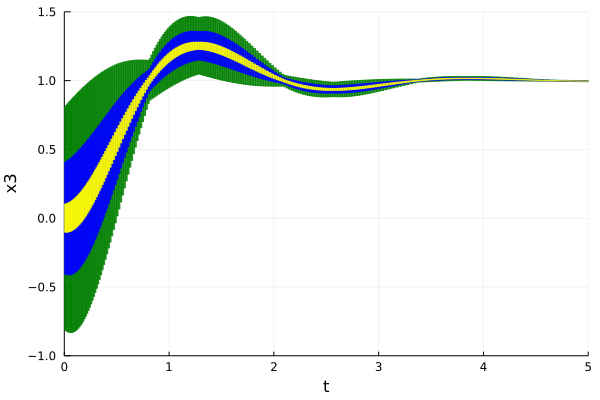

In [14]:
using Plots

Plots.plot(solz3,  vars=(0, 3), linecolor="green",  color=:green,  alpha=0.8)
Plots.plot!(solz2, vars=(0, 3), linecolor="blue",   color=:blue,   alpha=0.8)
Plots.plot!(solz1, vars=(0, 3), linecolor="yellow", color=:yellow, alpha=0.8,
    xlab="t", ylab="x3",
    xtick=[0., 1., 2., 3., 4., 5.], ytick=[-1., -0.5, 0., 0.5, 1., 1.5],
    xlims=(0., 5.), ylims=(-1., 1.5))